In [1]:
# Computations
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew

# Display
from colorama import Fore, Back, Style

# Testing
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# preprocessing
from sklearn import preprocessing

# Imputing Data
from sklearn.impute import SimpleImputer

# Train and Test sets
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Making pipline
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from mlxtend.regressor import StackingCVRegressor

# Plots

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon

# sns setting
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

# plt setting
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In this article, we would like to try the [Practice Problem: Black Friday](https://datahack.analyticsvidhya.com/contest/black-friday/?utm_source=auto-email) by [analyticsvidhya.com](https://www.analyticsvidhya.com/). You can download the required files from [here](https://datahack.analyticsvidhya.com/contest/black-friday/?utm_source=auto-email).

## Problem Statement

A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

#### Table of contents

* [Preprocessing](#Preprocessing)
* [Modeling](#Modeling)

### Loading the Data

In [2]:
Train = pd.read_csv("Data/train.csv")
Test = pd.read_csv("Data/test.csv")
print(Back.MAGENTA +'"%s":' % 'Train Data')
display(Train.head(4).style.hide_index())
print(Back.CYAN +'"%s":' % 'Test Data')
display(Test.head(4).style.hide_index())

"Train Data":


User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
1000001,P00069042,F,0-17,10,A,2,0,3,nan,nan,8370
1000001,P00248942,F,0-17,10,A,2,0,1,6.000000,14.000000,15200
1000001,P00087842,F,0-17,10,A,2,0,12,nan,nan,1422
1000001,P00085442,F,0-17,10,A,2,0,12,14.000000,nan,1057


"Test Data":


User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
1000004,P00128942,M,46-50,7,B,2,1,1,11.000000,nan
1000009,P00113442,M,26-35,17,C,0,0,3,5.000000,nan
1000010,P00288442,F,36-45,1,B,4+,1,5,14.000000,nan
1000010,P00145342,F,36-45,1,B,4+,1,4,9.000000,nan


# Initial Analysis

Creating a new dataframe by combining <font color='blue'>**Test**</font> and <font color='blue'>**Train**</font> sets.

In [3]:
# keep sort False in case you do not require the names of the columns in alphabetical order
Data = pd.concat([Train, Test], sort=False)
Data.head(4).style.hide_index()

User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
1000001,P00069042,F,0-17,10,A,2,0,3,nan,nan,8370.000000
1000001,P00248942,F,0-17,10,A,2,0,1,6.000000,14.000000,15200.000000
1000001,P00087842,F,0-17,10,A,2,0,12,nan,nan,1422.000000
1000001,P00085442,F,0-17,10,A,2,0,12,14.000000,nan,1057.000000


,Female,Male
Count,193636,590031


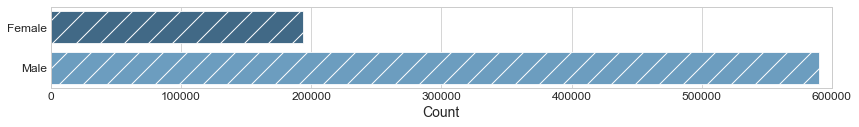

In [4]:
Group = pd.DataFrame(Data.groupby('Gender')['Gender'].count())
Group.columns = ['Count']
Group.index = ['Female', 'Male']
display(Group.T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 1.5), sharex = True)
_ = sns.barplot(y = Group.index, x='Count', palette="Blues_d", data=Group, ax = ax, hatch = '/')
_ = ax.set_xlabel('Count')
_ = ax.set_xlim([0,6e5])

Age,0-17,18-25,26-35,36-45,46-50,51-55,55+
Count,21334,141953,313015,156724,65278,54784,30579


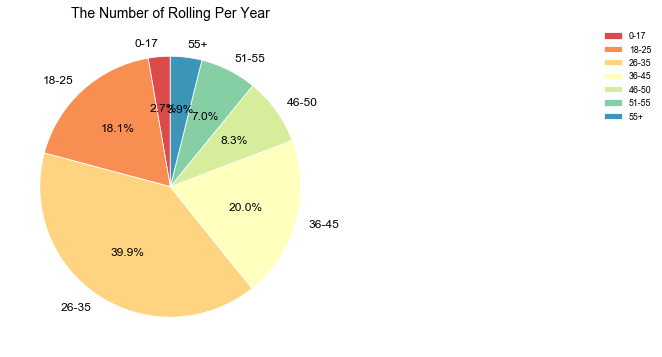

In [5]:
Group = pd.DataFrame(Data.groupby('Age')['Age'].count())
Group.columns = ['Count']
display(Group.T)

fig, ax = plt.subplots(1,1, figsize=(6,6))
_ = Group.plot.pie(y='Count', startangle=90, legend=False,label='',ax=ax, autopct='%1.1f%%',
                   colors = sns.color_palette("Spectral", len(Group)), fontsize=12)
_ = ax.legend(bbox_to_anchor=(2, 1))
_ = ax.set_title('The Number of Rolling Per Year')

Marital_Status,No,Yes
Count,462538,321129


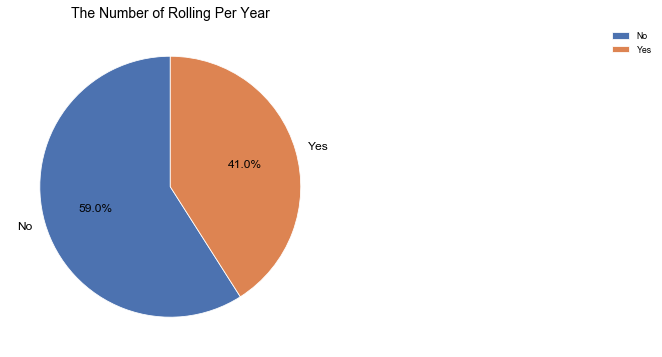

In [6]:
Temp= Data.copy()
Temp['Marital_Status'] = Temp['Marital_Status'].map({1: "Yes", 0: "No"})
Group = pd.DataFrame(Temp.groupby('Marital_Status')['Marital_Status'].count())
Group.columns = ['Count']
del Temp
display(Group.T)

fig, ax = plt.subplots(1,1, figsize=(6,6))
_ = Group.plot.pie(y='Count', startangle=90, legend=False,label='',ax=ax, autopct='%1.1f%%',
                   colors = sns.color_palette("deep", len(Group)), fontsize=12)
_ = ax.legend(bbox_to_anchor=(2, 1))
_ = ax.set_title('The Number of Rolling Per Year')

In [7]:
def Search_Columns(Inp, df= Data):
    ''' Search for specific value (Inp)'''
    Columns_list = df.columns.tolist()
    mylist=list()
    for i in range(len(Columns_list)):
        if Columns_list[i].find(Inp) != -1:
            mylist.append(Columns_list[i])
    return mylist

# Preprocessing

In [8]:
def NaN_Table(Inp):
    Out = pd.DataFrame(Inp.isnull().sum(), columns=['Number of NaN Values'])
    Out['Percentage'] = np.round(100*(Out['Number of NaN Values']/Inp.shape[0]),2)
    Out = Out[Out['Number of NaN Values']>0]
    display(Out)
    return Out.index.tolist()
def Data_Type_Table(Inp):
    Out = pd.DataFrame(Inp.dtypes,columns=['Data Type']).sort_values(by=['Data Type'])
    display(Out)
    return Out

In [9]:
display(Data.describe())
Data_Type = Data_Type_Table(Data)
NaN_Columns = NaN_Table(Data)

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,7.836670e+05,783667.000000,783667.000000,783667.000000,537685.000000,237858.000000,550068.000000
mean,1.003029e+06,8.079300,0.409777,5.366196,9.844506,12.668605,9263.968713
std,1.727267e+03,6.522206,0.491793,3.878160,5.089093,4.125510,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001519e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003075e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


,Data Type
User_ID,int64
Occupation,int64
Marital_Status,int64
Product_Category_1,int64
Product_Category_2,float64
Product_Category_3,float64
Purchase,float64
Product_ID,object
Gender,object
Age,object


,Number of NaN Values,Percentage
Product_Category_2,245982,31.39
Product_Category_3,545809,69.65
Purchase,233599,29.81


In particular, we can see that

In [10]:
Null = Data[Data.isna()][NaN_Columns]
Null.head()

,Product_Category_2,Product_Category_3,Purchase
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


We can drop these values.

In [11]:
Data = Data.dropna()
Data[NaN_Columns] = Data[NaN_Columns].astype(int)

Note that now,

In [12]:
NaN_Table(Data)

,Number of NaN Values,Percentage


[]

## Sets

For the next part, we can use **[LabelEncoder](#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)** for converting categorical to numeric using. Therefore,

In [13]:
Categorical_List = Data_Type[~Data_Type['Data Type'].isin(['int64', 'float64'])]
# Product_ID
le_Product_ID = preprocessing.LabelEncoder()
le_Product_ID.fit(list(Data['Product_ID']))
Data.loc[:,['Product_ID']] = le_Product_ID.transform(Data.loc[:,['Product_ID']])
# Gender
le_Gender = preprocessing.LabelEncoder()
le_Gender.fit(list(Data['Gender']))
Data.loc[:,['Gender']] = le_Gender.transform(Data.loc[:,['Gender']])
# Age
le_Age = preprocessing.LabelEncoder()
le_Age.fit(list(Data['Age']))
Data.loc[:,['Age']] = le_Age.transform(Data.loc[:,['Age']])
# City_Category
le_City_Category = preprocessing.LabelEncoder()
le_City_Category.fit(list(Data['City_Category']))
Data.loc[:,['City_Category']] = le_City_Category.transform(Data.loc[:,['City_Category']])
# Stay_In_Current_City_Years
le_Stay_In_Current_City_Years = preprocessing.LabelEncoder()
le_Stay_In_Current_City_Years.fit(list(Data['Stay_In_Current_City_Years']))
Data.loc[:,['Stay_In_Current_City_Years']] = le_Stay_In_Current_City_Years.transform(Data.loc[:,['Stay_In_Current_City_Years']])
# Finally
_ = Data_Type_Table(Data)

,Data Type
Product_ID,int32
Gender,int32
Age,int32
City_Category,int32
Stay_In_Current_City_Years,int32
Product_Category_2,int32
Product_Category_3,int32
Purchase,int32
User_ID,int64
Occupation,int64


Thus, we have converted this set

# Modeling

In [14]:
def Scoring(clf, X, y):
    Out = pd.DataFrame(np.array([[clf.score(X, y),
                            mean_squared_error(y_test, clf.predict(X_test)),
                            r2_score(y_test, clf.predict(X_test))]]),
                       columns=['Score', 'MSE', 'Variance score'])
    return Out.style.hide_index()
    return Out

In [15]:
Target = 'Purchase'
X = Data.drop(columns = Target)
Y = Data[Target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
             'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).style.hide_index()

Set,Shape
X_train,"(111770, 11)"
X_test,"(55051, 11)"
y_train,"(111770,)"
y_test,"(55051,)"


## Developing a model

In [16]:
#
lr = LinearRegression().fit(X_train, y_train)
lr2 = make_pipeline(preprocessing.RobustScaler(), lr).fit(X_train, y_train)
#
ridge = RidgeCV(alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1.5, 2, 4, 10, 16]).fit(X_train, y_train)
ridge2 = make_pipeline(preprocessing.RobustScaler(), ridge).fit(X_train, y_train)
#
lasso = LassoCV(alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1.5, 2, 4, 10, 16]).fit(X_train, y_train)
lasso2 = make_pipeline(preprocessing.RobustScaler(), lasso).fit(X_train, y_train)
#
elastic = ElasticNet().fit(X_train, y_train)
elastic2 = make_pipeline(preprocessing.RobustScaler(), elastic).fit(X_train, y_train)
#
br = BaggingRegressor().fit(X_train, y_train)
br2 = make_pipeline(preprocessing.RobustScaler(), br).fit(X_train, y_train)
#
gbr = GradientBoostingRegressor().fit(X_train, y_train)
gbr2 = make_pipeline(preprocessing.RobustScaler(), gbr).fit(X_train, y_train)
#
rfr = RandomForestRegressor().fit(X_train, y_train)
rfr2 = make_pipeline(preprocessing.RobustScaler(), rfr).fit(X_train, y_train)
# Stacking
stacked = StackingCVRegressor(regressors=(lr2, lasso2, br2, gbr2, rfr2),
                              meta_regressor=rfr2,
                              use_features_in_secondary=True).fit(X_train, y_train)
del lr, ridge, lasso, br, gbr, rfr

In [17]:
Scoring(stacked, X_test, y_test)

Score,MSE,Variance score
0.577684,10871729.443879,0.577684


In [27]:
Predictions = stacked.predict(X_test)
print('Minimum = %f, Maximum = %f'% (Predictions.min(), Predictions.max()))

Minimum = 315.480000, Maximum = 22554.720000


## XGBoost modeling

First, we can try **[XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)** which provides a gradient boosting framework. First, we need to set up the parameters. For a quick review, please see [this link](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) and [this link](https://xgboost.readthedocs.io/en/latest/parameter.html).

In [18]:
# creating an empty dictionary
params = {}
params["silent"] = 1
params["eta"] = 0.11
params["min_child_weight"] = 11
params["scale_pos_weight"] = 0.7
params["seed"] = 0
params["base_score"] = 1800
params["subsample"] = 0.6
params["colsample_bytree"] = 0.6

parm_list = list(params.items())
Steps = 1500

For the next part, we use **[DMatrix](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=dmatrix#xgboost.DMatrix)** which transforms a numpy array of data to a **DMatrix object**.

In [19]:
xgtrain = xgb.DMatrix(X_train, label=y_train)

Creating a model using **[xgb.train](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=xgb%20train#xgboost.train)**:

In [20]:
model = xgb.train(parm_list, xgtrain, Steps)

In [25]:
Predictions = model.predict(xgb.DMatrix(X_test))
display(pd.DataFrame(np.array([[mean_squared_error(y_test, Predictions), r2_score(y_test, Predictions)]]),
                       columns=['MSE', 'Variance score']))
print('Minimum = %f, Maximum = %f'% (Predictions.min(), Predictions.max()))

,MSE,Variance score
0,9.314272e+06,0.638184


Minimum = -2601.385742, Maximum = 23160.019531


Since we are talking about purchases, <font color='red'>*negative values do not make sense!*</font>.

Therefore, for this example, we would recommend the stacked model for predictions. However, this model still can be improved by stacking some of the iterative models, such as XGBoost that we have used.

***